This notebook contains the code for:
- feature engineering 
- dimensionality reduction using UMAP
- clustering using HDBSCAN

In [1]:
import numpy as np     
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import random

In [4]:
import umap
import hdbscan

In [5]:
import joblib 
from joblib import Parallel, delayed

In [6]:
from sklearn.decomposition import PCA

In [7]:
import sys
sys.path.append('../utils/')

In [8]:
from wavelets import get_wv_parameters, wv_transform

# Load metadata

In [9]:
df_meta = pd.read_pickle('../../data/amphioxus_metadata_final500.pickle')

In [10]:
# create a filename column to match with the filename column in the dataset
df_meta['filename'] = df_meta['filename_video'].apply(lambda x: x.split('.avi')[0])

In [11]:
len(df_meta.filename.unique())

500

# Load the data (postural and kineamtic features computed from DLC tracking)

In [12]:
df = pd.read_hdf('../../results/featureset_v5_08082023.h5', key='features')

###  Thresholding ```speed_MOUTH```

This code should be moved under creation of the feature-dataset (under outlier removal)
- This is should ideally be done while creating the feature dataset. 
Since the ```speed_MOUTH``` feature has not been previously processed for outlier detection, I am doing it here using simple thresholding


In [13]:
# df[df['speed_MOUTH'] < 50]['speed_MOUTH'].hist(bins=100)

In [14]:
# df = df[(df['speed_MOUTH'].isna())|(df['speed_MOUTH'] < 20)]

# Selecting features to be used for analysis

## Speeds

In [15]:
df_speeds = df.filter(like='speed')
df_speeds.shape

(3948425, 27)

In [16]:
df_speeds[df_speeds['speed_MOUTH'].isna()] = -1

/tmp/ipykernel_2387495/3663971568.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_speeds[df_speeds['speed_MOUTH'].isna()] = -1
/tmp/ipykernel_2387495/3663971568.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_speeds[df_speeds['speed_MOUTH'].isna()] = -1


In [17]:
df_speeds = df_speeds.fillna(value=-5) # Nan masking

## Using curvatures (curvatures have been computed for dorsal points only)

In [18]:
df_curv = df.filter(like='curv')
df_curv.shape

(3948425, 15)

How to use curvatures in the analysis? 
- We would like to encode the temporal dynamics (how does the curvatures change along time?)
- One obvious way to do it is to use wavelets which can encode multiresolution - spatial and temporal features
- Then the question becomes, how do we use the curvatures? 
    1. Option 1: Compute wavelets for all 15 curvature points.
    2. Option 2: First use PCA to capture much of the variance in curvatures. Will that suffice? 

### Try PCA ~ akin to eigen cionas, eigen worms etc

In [19]:
pca = PCA()
pca_curv = pca.fit_transform(df_curv)
pca_curv.shape

(3948425, 15)

Text(0, 0.5, 'variance explained')

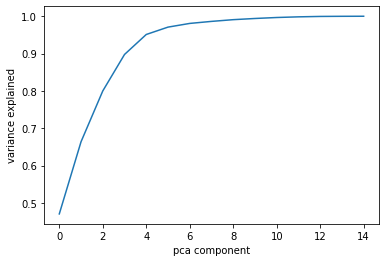

In [20]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('pca component')
plt.ylabel('variance explained')

In [21]:
np.cumsum(pca.explained_variance_ratio_)

array([0.47068966, 0.66389723, 0.79995104, 0.89763586, 0.95116686,
       0.97087868, 0.98077276, 0.98620937, 0.99082476, 0.99399934,
       0.99662775, 0.99839621, 0.99948425, 0.99983495, 1.        ])

In [22]:
np.where(np.cumsum(pca.explained_variance_ratio_)<0.98)

(array([0, 1, 2, 3, 4, 5]),)

if we use the first 6 pca components, it can explain > 97% of the variance in the data

In [ ]:
for i in range(6):
    df[f'pca_{i}'] = pca_curv[:,i]

### Compute wavelet transforms

In [ ]:
# Wavelet features has to be computed for each file

df_files = df.groupby(by = 'filename')

df_pca_feats = []
pca_feats = [f'pca_{i}' for i in range(6)]

for fn, group in df_files:
    df_pca_feats.append(group.filter(items = pca_feats + ['filename', 'frame']))

In [ ]:
omg0, widths = get_wv_parameters()

In [ ]:
df_wv_transforms = Parallel(n_jobs=40, verbose = 5)(delayed(wv_transform)(df, widths, omg0) 
                                                for df in df_pca_feats)

In [ ]:
df_wavelets = pd.concat(df_wv_transforms)

In [ ]:
df_wavelets.shape

# UMAP

## for speeds

In [23]:
reducer_speeds = umap.UMAP(n_jobs=40) # assuming euclidean metrics will do fine

In [ ]:
embedding_speeds = reducer_speeds.fit_transform(df_speeds.values)
embedding_speeds.shape

In [ ]:
fn_model_speeds = f'../../results/umap_model_speeds_10082023a_all.joblib'
joblib.dump(reducer_speeds, fn_model_speeds)

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(15,7))
axes.scatter(embedding_speeds[:, 0],embedding_speeds[:, 1], s=0.2)
axes.set_aspect('equal')

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(15,15), sharex=True)
axes= axes.ravel()
axes[0].scatter(embedding_speeds[:, 0],embedding_speeds[:, 1], s=0.2)

hue_feats = {'mouth': df['speed_MOUTH'],
             'quirkiness': df['quirkiness'],
             'mean_dorsal_speeds': df.filter(like='speed_D').mean(axis=1),
             'mean_ventral_speeds': df.filter(like='speed_V').mean(axis=1),
             'mean_speeds': df.filter(like='speed_').mean(axis=1),
#              'length': df['len_sum_of_parts'],
             'mean_curv': df.filter(like='curv').abs().mean(axis=1),
             'speed_NT': df['speed_NT'],
            }

for i, key_hue in enumerate(hue_feats.keys()):
    axes[i+1].scatter(embedding_speeds[:, 0],embedding_speeds[:, 1], c= hue_feats[key_hue], s=0.2)
    axes[i+1].set_title(key_hue)
for ax in axes:  
    ax.set_aspect('equal', 'datalim')
fig.savefig('../../results/umap_speeds_10082023a.png')

## for wavelets (curvatures)

In [ ]:
reducer_wavelets = umap.UMAP(n_jobs=40)

In [ ]:
embedding_wavelets = reducer_wavelets.fit_transform(df_wavelets.filter(like='wv').values)
embedding_wavelets.shape

In [ ]:
fn_model_wavelets = f'../../results/umap_model_wavelets_09082023_all.joblib'
joblib.dump(reducer_wavelets, fn_model_wavelets)

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(15,7))
axes.scatter(embedding_wavelets[:, 0],embedding_wavelets[:, 1], s=0.2)
axes.set_aspect('equal')

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(15,15), sharex=True)
axes= axes.ravel()
axes[0].scatter(embedding_wavelets[:, 0],embedding_wavelets[:, 1], s=0.2)

hue_feats = {'mouth': df['speed_MOUTH'],
             'quirkiness': df['quirkiness'],
             'mean_dorsal_speeds': df.filter(like='speed_D').mean(axis=1),
             'mean_ventral_speeds': df.filter(like='speed_V').mean(axis=1),
             'mean_speeds': df.filter(like='speed_').mean(axis=1),
#              'length': df['len_sum_of_parts'],
             'mean_curv': df.filter(like='curv').abs().mean(axis=1),
             'speed_NT': df['speed_NT'],
            }

for i, key_hue in enumerate(hue_feats.keys()):
    axes[i+1].scatter(embedding_wavelets[:, 0],embedding_wavelets[:, 1], c= hue_feats[key_hue], s=0.2)
    axes[i+1].set_title(key_hue)
for ax in axes:  
    ax.set_aspect('equal', 'datalim')
fig.savefig('../../results/umap_wavelets_09082023.png')